# Import Disturbances Data

In [1]:
import geopandas as gpd
import pandas as pd
from datetime import datetime
import os 

directory = '/Users/arthurcalvi/Data/results/disturbances/matching_france_v04_EPSG3857.parquet'
gdf = gpd.read_parquet(directory)
gdf.shape[0]

14813609

In [2]:
#drop duplicates

gdf.drop_duplicates(subset=['index_SS', 'year'], inplace=True)
gdf.shape[0]

5870700

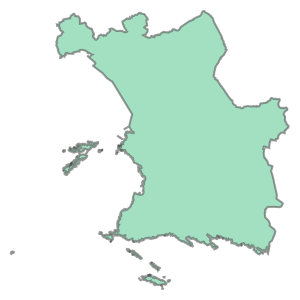

In [30]:
#retrieve polygon of small region
from OSMPythonTools.nominatim import Nominatim
from shapely import wkt
region = "Marseille"
finder = Nominatim()
spatial_entity = finder.query(region, wkt=True)
pol = wkt.loads(spatial_entity.wkt())
spatial_entity.displayName()
from rasterio.warp import transform_geom
from shapely.geometry import shape
pol_ = shape(transform_geom('EPSG:4326', 'EPSG:3857', pol))
pol_

In [4]:
gdf.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
#clip
gdf = gdf.clip(pol_.buffer(5000).simplify(5000))

In [95]:
#pul pol_ in a geodataframe
gdf_pol = gpd.GeoDataFrame(geometry=[pol_], crs='EPSG:3857')

# Get neighbors

In [155]:
#pick a random row from gdf and create a 9.5 x 9.5 km bounding box
import random
random.seed()
random_row = random.randint(0, gdf.shape[0])
row = gdf.iloc[[random_row]]
display(row)

,index_SS,year,geometry,class_SS,index_DFDE,start_date_DFDE,end_date_DFDE,name,class_DFDE,index_FI,class_FI,start_date_FI,end_date_FI,sjoin_distance,overlap_DFDE_FI,area_DFDE,class,probability
17272398,5868933,2018,"POLYGON ((617525.561 5351630.888, 617520.995 5...",Fire,NaN,NaT,NaT,None,None,55454.0,Fire,2011-12-28 18:00:00,2016-12-28,6351.043291,False,NaN,Fire,0.46


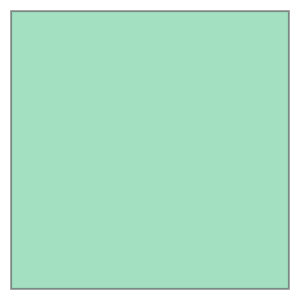

In [156]:
#create a shapely point from the row and the bounding box
from shapely.geometry import Point
point = Point(row.geometry.centroid.x, row.geometry.centroid.y)
point.buffer(4750, cap_style=3)

In [160]:
%%time
# gdf_aoi = gpd.GeoDataFrame(geometry=[point.buffer(4750, cap_style=3)], crs='EPSG:3857')
# neighbors = gdf.overlay(gdf_aoi, how='intersection')
neighbors = gdf.clip(point.buffer(4750, cap_style=3))
neighbors = neighbors.append(row)


CPU times: user 60.2 ms, sys: 3.41 ms, total: 63.6 ms
Wall time: 61.2 ms


<timed exec>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Text(0.5, 1.0, 'Cover ratio: 60.67%')

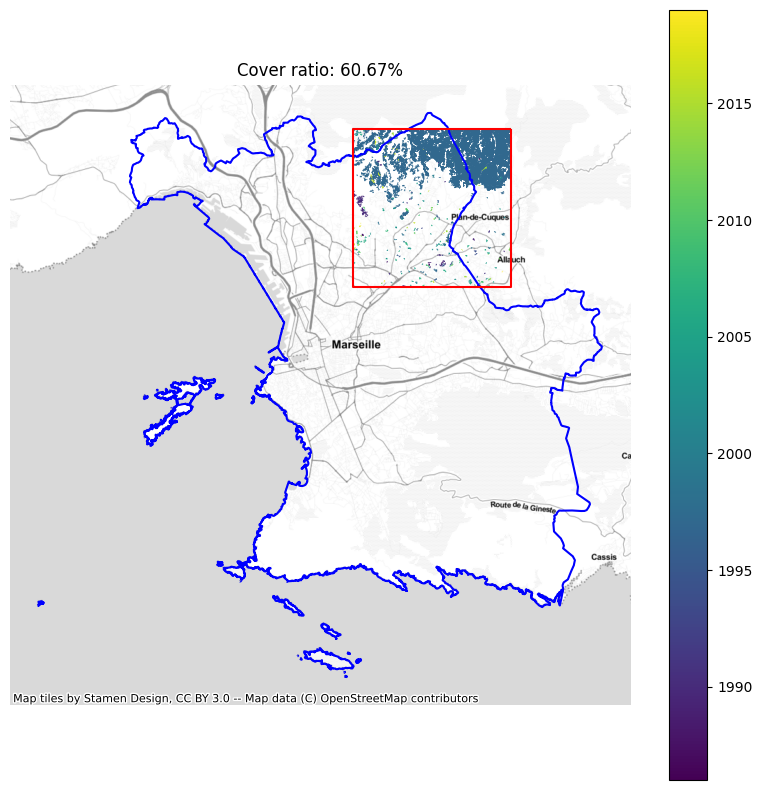

In [101]:
import contextily as cx
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(10,10))
gdf_pol.boundary.plot(ax=axes, color='blue')
gdf_aoi.boundary.plot(ax=axes, color='red')
neighbors.plot(ax=axes, column='year', legend=True)
cx.add_basemap(axes, crs=neighbors.crs.to_string(), source=cx.providers.Stamen.TonerLite)
axes.set_axis_off()

#cover ratio as title
cover_ratio = neighbors.area.sum() / gdf_aoi.area.sum()
plt.title(f'Cover ratio: {cover_ratio:.2%}')

# Metric to differentiate AOI


In [162]:
def get_bounding_box(row, gdf):
    aoi = Point(row.geometry.centroid.x, row.geometry.centroid.y)
    neighbors = gdf.clip(aoi.buffer(4750, cap_style=3))
    neighbors = neighbors.append(row)
    return neighbors, aoi

def get_random_bounding_box(gdf):
    random_row = random.randint(0, gdf.shape[0])
    row = gdf.iloc[[random_row]]
    return get_bounding_box(row, gdf)

In [144]:
_, b1 = get_random_bounding_box(gdf)
_, b2 = get_random_bounding_box(gdf)

/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6762/2281764403.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neighbors = neighbors.append(row)
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6762/2281764403.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neighbors = neighbors.append(row)


In [163]:
list_b1 = [get_random_bounding_box(gdf)[1] for i in range(100)]
list_b2 = [get_random_bounding_box(gdf)[1] for i in range(100)]

/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6762/4182099039.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neighbors = neighbors.append(row)
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6762/4182099039.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neighbors = neighbors.append(row)
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6762/4182099039.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neighbors = neighbors.append(row)
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_6762/4182099039.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neighbors = neighbors.append(row)


In [166]:
%%time
#COMPUTE IoU

for i in range(100):
    bounds1 = list_b1[i]
    bounds2 = list_b2[i]
    if bounds1.intersects(bounds2):
        IoU = bounds1.intersection(bounds2).area / bounds1.union(bounds2).area
    else: 
        IoU = 0


CPU times: user 4.21 ms, sys: 2.63 ms, total: 6.84 ms
Wall time: 5.05 ms


In [168]:
%%time 
#COMPUTE Distance
for i in range(100):
    b1 = list_b1[i]
    b2 = list_b2[i]
    c1 = Point(b1.centroid.x, b1.centroid.y)
    c2 = Point(b2.centroid.x, b2.centroid.y)
    distance = c1.distance(c2)

CPU times: user 17.3 ms, sys: 2.89 ms, total: 20.2 ms
Wall time: 20.2 ms
